<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Ames Housing Data and Kaggle Challenge

## Executive Summary
---
This project seeks to develop a housing sale price prediction model to help home sellers overcome imperfect information in the housing market, so that they can reliably predict housing prices and sell their houses at a fair value. 

Our attempt to develop a model yielded poor predictions on first try. This poor outcome is likely due to the highly restrictive feature selection process from the outset. We did not accomplish the intended goal of achieving predictions with root mean squared error lower than the cost of imperfect information in the housing market (estimated to be ~ \$10,000 per sale). From this, we learn that there is a need to include more features (> 30) to train future models so that it can account for the wide variations sale prices in the unseen data. 

Beyond building a more complex model for housing sale price predictions, data scientist can also replicate the modelling process using housing sales dataset from other regions in the US (outside of Ames, Iowa) in future so that the model can be extended to predict housing prices in other geographical areas. 

## Background
---

With little understanding of the housing market, home sellers may encounter unfortunate events of mispricing of housing units at their point of sale.

[Levitt and Syverson (2008)](https://ideas.repec.org/a/tpr/restat/v90y2008i4p599-611.html) flagged that **agents were often better informed than the clients who hire them**. Real estate agents may exploit this informational advantage and convince their clients to sell their houses too cheaply. Based on their research while controlling for observables, **they found that homes owned by real estate agents sold for 3.7% more than other houses**. This finding is worrying as it suggests that home sellers are likely to be disadvantaged when making a housing transaction with imperfect information.

> According to the [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ASPUS), the average sales price of houses sold for the United States is **\$278,000** in 2010 Q4. 

What this means is that imperfect information could cause home sellers to lose ~ **\$10,000** (i.e. 3.7% * \$278k) in housing value for the average transaction! 

Given there are **4.18 million** homes sold in the United States in 2010 [(source)](https://www.statista.com/statistics/226144/us-existing-home-sales/), the total cost of housing units mispricing (assuming 95% of these homes are not property agent owned) can come up to **\\$39 billion** per annum (i.e. 4.18million * \$10k) ! 

## Problem Statement
---

We want to help **uninformed home sellers** understand what constitute as fair housing prices by developing a regression model to **predict the sale prices of houses**. Specifically, we use linear models, i.e. ordinary least squares (OLS), Ridge and Lasso regressions. 

A successful housing price prediction model should be able to **predict housing prices with error term or root mean squared error that is ideally lower than $10,000** (i.e. the cost of imperfection information in the housing market).

## Data 
---

We model and predict housing prices using the following datasets, drawn from housing sales in Ames, Iowa from 2006 to 2010:

* `Train data:` [train.csv](./data/train.csv)
* `Test data:` [test.csv](./data/test.csv)

A data dictionary for the variables included in these datasets can be found [here](https://www.kaggle.com/c/dsi-us-11-project-2-regression-challenge/data). 

## Methodology
---

This project follows the following workflow:

**1) Feature Selection**
Apart from the housing sale prices, the train and test datasets contain 80 housing-related variables. We exercise judgement to include only select features that will most likely affect housing sale prices within our baseline model. This is to mitigate risks of overfitting and multicollinearity. We use pairplots to provide visualise and assess:

- Whether variable has a linear relationship with target sale prices
- The amount of variations within each variable 
- Possible collinearity and relationship between similar variables

**2) Data Cleaning**
We impute missing values and remove outliers.

**3) Features Engineering**
We dummify categorical variables (using drop_first), assign numerical rank values for ordinal variables, add interaction terms and engineer new features to strengthen the linear relationship of variable(s) with sale prices. 

**4) Model Preparation**
We use the train-test split method to evaluate our model and scale our train (and test) data accordingly using StandardScaler.

**5) Model Selection & Deployment**
The best model among OLS, Ridge and Lasso regressions are selected using r2 scores metrics based on cross validation and initial model fitting between the train and test sets. 

The best model is then fitted and deployed to predict housing sale prices in the test data. 

## Data Import and Cleaning
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
print("train:", train.shape)
print("test:", test.shape)

train: (2051, 81)
test: (878, 80)


In [4]:
### Standardizing the format of the column names 
train.columns = train.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace(' ', '_')

### Housing prices are likely associated with the size of living area. 
### We scatter `saleprice` against `gr_liv_area` (i.e. above grade (ground) living area square feet) in square feet to check for outliers.

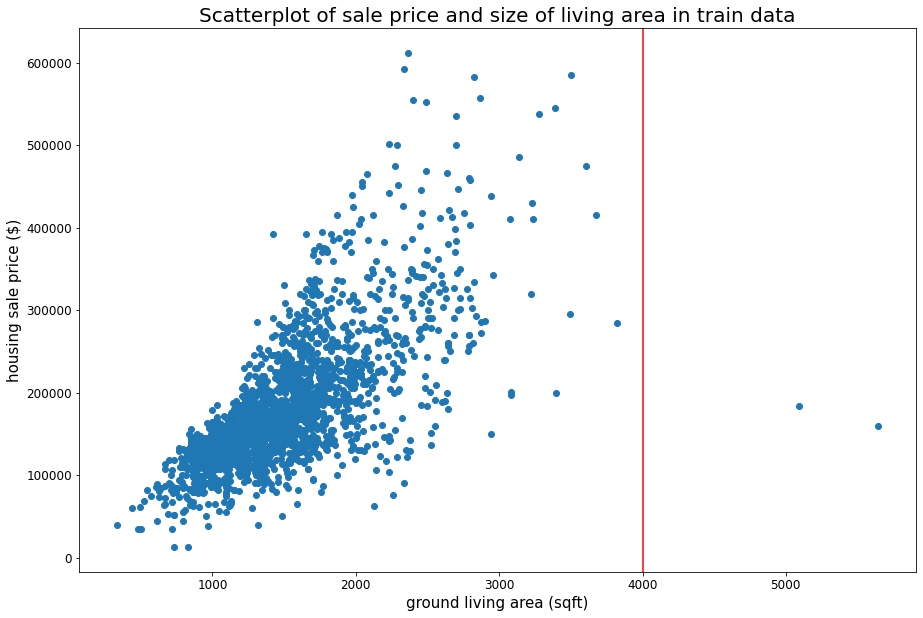

In [5]:
plt.figure(figsize=(15,10))
plt.title("Scatterplot of sale price and size of living area in train data", fontsize=20)
plt.ylabel("housing sale price ($)", fontsize=15)
plt.xlabel("ground living area (sqft)", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.axvline(4000, color="r")
plt.scatter(train["gr_liv_area"], train["saleprice"]);

(array([119., 823., 771., 231.,  90.,  12.,   3.,   0.,   1.,   1.]),
 array([ 334. ,  864.8, 1395.6, 1926.4, 2457.2, 2988. , 3518.8, 4049.6,
        4580.4, 5111.2, 5642. ]),
 <BarContainer object of 10 artists>)

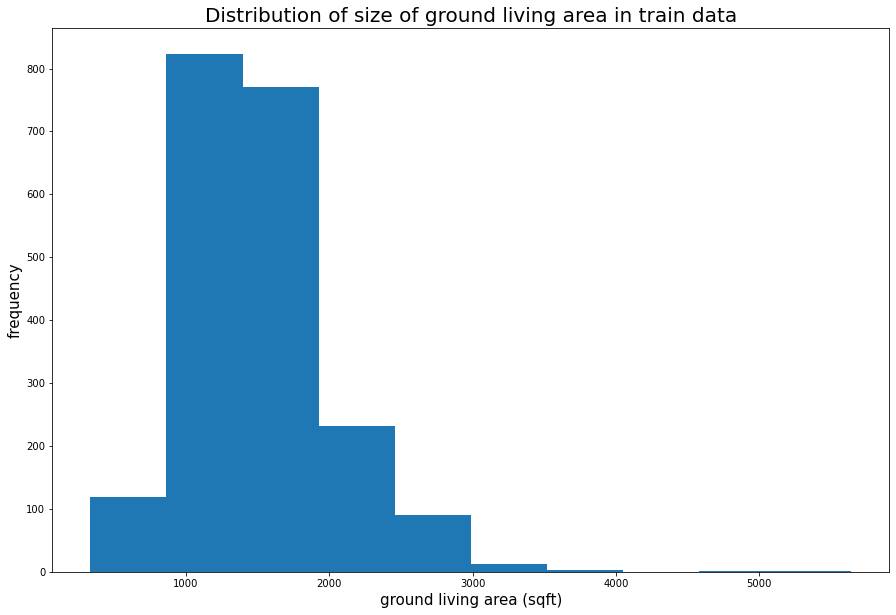

In [6]:
plt.figure(figsize=(15,10))
plt.title("Distribution of size of ground living area in train data", fontsize=20)
plt.ylabel("frequency", fontsize=15)
plt.xlabel("ground living area (sqft)", fontsize=15)
plt.hist(train["gr_liv_area"])

### Majority of the housing units have ground living area lower than 4,000 square feet. Therefore, it would not cause too much skewing of actual train data if we drop the 2 outliers above (i.e. houses with >4,000 sqft living area being sold for < $200,000).

In [7]:
train = train.loc[train["gr_liv_area"] < 4000]
train.shape

(2049, 81)

### We plot a series of histogram plots to 
* ### (i) eyeball the distribution of the numerical variables; and, 
* ### (ii) spot data entry error(s) within the train dataset.

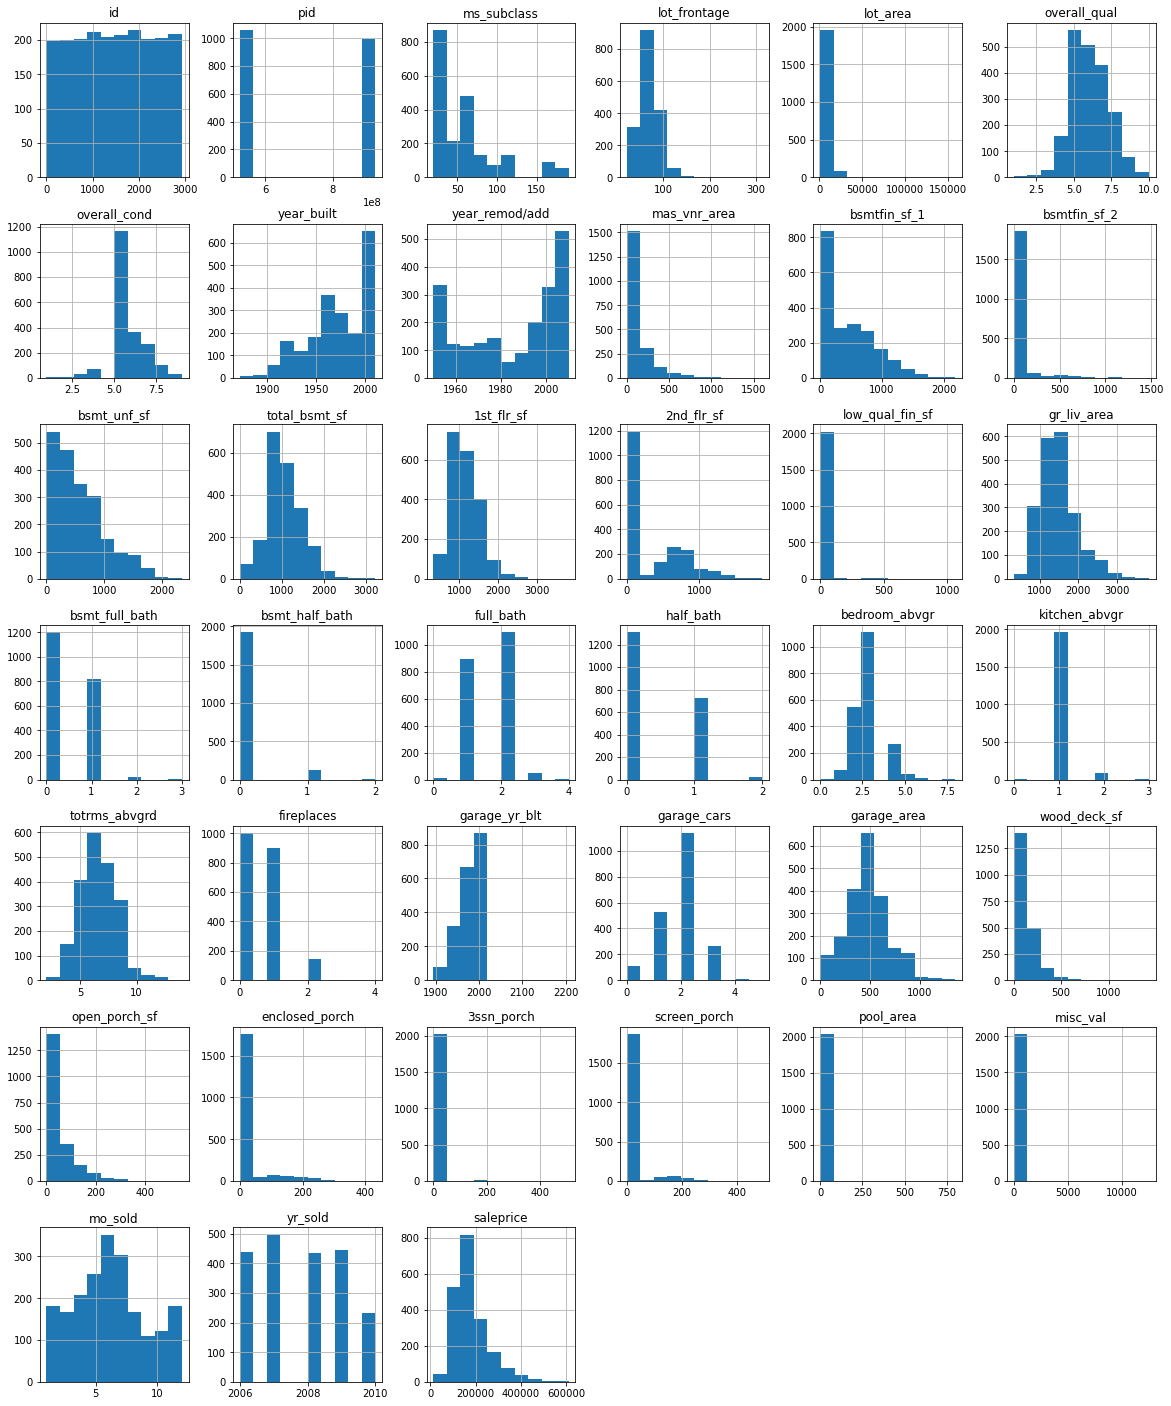

In [8]:
train.hist(figsize=(20, 25));

### We remove the row with data entry error under *garage_yr_blt* below as it cannot possibly be built after 2010. 

In [9]:
train.drop(train[train["garage_yr_blt"] > 2011].index, inplace=True)
train.shape

(2048, 81)

### After removing the outliers and error, we proceed to drop variables with no clear linear relationship with sale price (see pairplots).

### However, we will not include all variables showing linear relationships with sale price as it will risk multicollinearity.

> E.g. `*garage_cars*` and `*garage_area*` are likely to be highly related. 

\* For first cut, variables may be dropped based on subjective assessment. We can always add the variables back later if there is an issue of under-fitting.

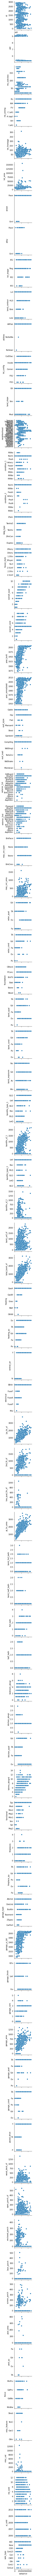

In [10]:
sns.pairplot(train, y_vars=['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'garage_finish', 'garage_cars', 'garage_area', 'garage_qual',
       'garage_cond', 'paved_drive', 'wood_deck_sf', 'open_porch_sf',
       'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'pool_qc',
       'fence', 'misc_feature', 'misc_val', 'mo_sold', 'yr_sold', 'sale_type'], 
             x_vars=['saleprice'])

In [11]:
train.drop(["id", "pid","ms_subclass", "ms_zoning", "street", "alley", "lot_shape", "utilities", "land_contour",
           "land_slope", "condition_1", "condition_2", "bldg_type", "house_style", "roof_style", "pool_qc",
           "roof_matl", "exterior_1st", "exterior_2nd", "mas_vnr_type", "mas_vnr_area", "foundation", "year_built",
           "bsmt_exposure", "bsmtfin_type_1", "bsmtfin_sf_1", "bsmtfin_type_2", "bsmtfin_sf_2", "bsmt_unf_sf",
           "heating", "electrical", "1st_flr_sf", "2nd_flr_sf", "low_qual_fin_sf", "totrms_abvgrd", 
           "garage_type", "garage_yr_blt", "garage_finish", "garage_cars", "paved_drive", "fence",  
            "misc_feature", "misc_val", "mo_sold", "sale_type"], 
           axis=1, inplace=True)

### We impute missing values within the train set below.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2050
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lot_frontage    1718 non-null   float64
 1   lot_area        2048 non-null   int64  
 2   lot_config      2048 non-null   object 
 3   neighborhood    2048 non-null   object 
 4   overall_qual    2048 non-null   int64  
 5   overall_cond    2048 non-null   int64  
 6   year_remod/add  2048 non-null   int64  
 7   exter_qual      2048 non-null   object 
 8   exter_cond      2048 non-null   object 
 9   bsmt_qual       1993 non-null   object 
 10  bsmt_cond       1993 non-null   object 
 11  total_bsmt_sf   2047 non-null   float64
 12  heating_qc      2048 non-null   object 
 13  central_air     2048 non-null   object 
 14  gr_liv_area     2048 non-null   int64  
 15  bsmt_full_bath  2046 non-null   float64
 16  bsmt_half_bath  2046 non-null   float64
 17  full_bath       2048 non-null   i

### Lot frontage may be related with different lot configuration. 

We impute the missing values for `lot_frontage` according to the mean of each `lot_config`. This would likely be more accurate then imputing the missing values based on the overall mean of the entire dataset.

In [13]:
train.groupby("lot_config")["lot_frontage"].mean()

lot_config
Corner     82.425000
CulDSac    55.228571
FR2        60.836735
FR3        87.000000
Inside     66.905416
Name: lot_frontage, dtype: float64

In [14]:
train["lot_frontage_imputed"] = train["lot_frontage"]

In [15]:
lot_config = ["Corner", "CulDSac", "FR2", "FR3", "Inside"]

for i in lot_config:
    train.loc[(train["lot_frontage"].isna()) & (train["lot_config"]==i), 
              "lot_frontage_imputed"] = train.groupby("lot_config")["lot_frontage"].mean()[i]

After imputing the missing values, we drop the `lot_frontage` & `lot_config` as they are no longer needed.

In [16]:
train.drop(["lot_frontage", "lot_config"], inplace=True, axis=1)

### We further impute missing values for the other variables below.

In [17]:
### e.g. NA quality for fireplace=0

missing_var = ["fireplace_qu", "bsmt_qual", "bsmt_full_bath", "bsmt_half_bath", "garage_area",
              "garage_qual", "total_bsmt_sf", "garage_cond", "bsmt_cond", "exter_cond", "pool_area"]

for i in missing_var:
    if train[i].dtype == "O":
        train[i].fillna("NA", inplace=True)
    else:
        train[i].fillna(0, inplace=True)

In [18]:
train.isnull().sum()

lot_area                0
neighborhood            0
overall_qual            0
overall_cond            0
year_remod/add          0
exter_qual              0
exter_cond              0
bsmt_qual               0
bsmt_cond               0
total_bsmt_sf           0
heating_qc              0
central_air             0
gr_liv_area             0
bsmt_full_bath          0
bsmt_half_bath          0
full_bath               0
half_bath               0
bedroom_abvgr           0
kitchen_abvgr           0
kitchen_qual            0
functional              0
fireplaces              0
fireplace_qu            0
garage_area             0
garage_qual             0
garage_cond             0
wood_deck_sf            0
open_porch_sf           0
enclosed_porch          0
3ssn_porch              0
screen_porch            0
pool_area               0
yr_sold                 0
saleprice               0
lot_frontage_imputed    0
dtype: int64

### Now that there are no more missing values, we proceed to engineer new features for our regression models.

In [19]:
### Feature engineering: aggregate similar or related variables

train["age"] = train["yr_sold"] - train["year_remod/add"]
train["porch_area"] = train["open_porch_sf"] + train["enclosed_porch"] + train["3ssn_porch"] + train["screen_porch"]
train["total_rooms"] = train["full_bath"] + train["half_bath"] +train["bedroom_abvgr"] + train["kitchen_abvgr"] + train["bsmt_full_bath"] + train["bsmt_half_bath"]

train.drop(["year_remod/add", "open_porch_sf", "enclosed_porch", "3ssn_porch", "screen_porch",
            "full_bath", "half_bath", "bedroom_abvgr", "kitchen_abvgr", "bsmt_full_bath", "bsmt_half_bath"], 
           axis=1, inplace=True)

In [20]:
### Feature engineering: change all the ordinal variables into numerical variables 
ordinal_var = ["bsmt_qual", "heating_qc", "kitchen_qual", "fireplace_qu", "garage_qual", "exter_qual",
              "exter_cond", "bsmt_cond", "garage_cond"]

for i in ordinal_var:
    train[i].replace({"Ex": 5, "Gd":4, "TA": 3, "Fa": 2, "Po":1, "NA": 0}, inplace=True)

In [21]:
### Feature engineering: come up with neighbourhood score based on:
# (i) % of housing units in the neighbourhood with typical functionality
# (ii) score of the overall quality and condition of housing units within each neighbourhood
# (iii) score of the exterior quality and condition of housing units within each neighbourhood

train["typical_functionality"] = 0
train.loc[(train["functional"] == "Typ"), "typical_functionality"] = 1
train.drop("functional", axis=1, inplace=True)

# Create interaction variables between overall_qual & overall_cond AND exter_qual & exter_cond
train["overall_qual*cond"] = train["overall_qual"] * train["overall_cond"]
train["exter_qual*cond"] = train["exter_qual"] * train["exter_cond"]

neighborhd = train.groupby("neighborhood", as_index=False)[["typical_functionality", "overall_qual*cond", "exter_qual*cond" ]].mean()
neighborhd["tf_rank"] = neighborhd["typical_functionality"].rank()
neighborhd["overall_rank"] = neighborhd["overall_qual*cond"].rank()
neighborhd["exter_rank"] = neighborhd["exter_qual*cond"].rank()
neighborhd["composite_rank_score"] = neighborhd["tf_rank"] + neighborhd["overall_rank"] + neighborhd["exter_rank"]
neighborhd["rank_order"] = neighborhd["composite_rank_score"].rank()

neighborhd["neighborhood_score"] = 0
neighborhd.loc[(neighborhd["rank_order"] <= 4), "neighborhood_score"] = 1
neighborhd.loc[(neighborhd["rank_order"] <= 8) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 2
neighborhd.loc[(neighborhd["rank_order"] <= 12) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 3
neighborhd.loc[(neighborhd["rank_order"] <= 16) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 4
neighborhd.loc[(neighborhd["rank_order"] <= 20) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 5
neighborhd.loc[(neighborhd["rank_order"] <= 24) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 6
neighborhd.loc[(neighborhd["rank_order"] <= 28) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 7

train = train.merge(neighborhd[["neighborhood", "neighborhood_score"]], how="inner", on="neighborhood")
train.drop("neighborhood", axis=1, inplace=True)

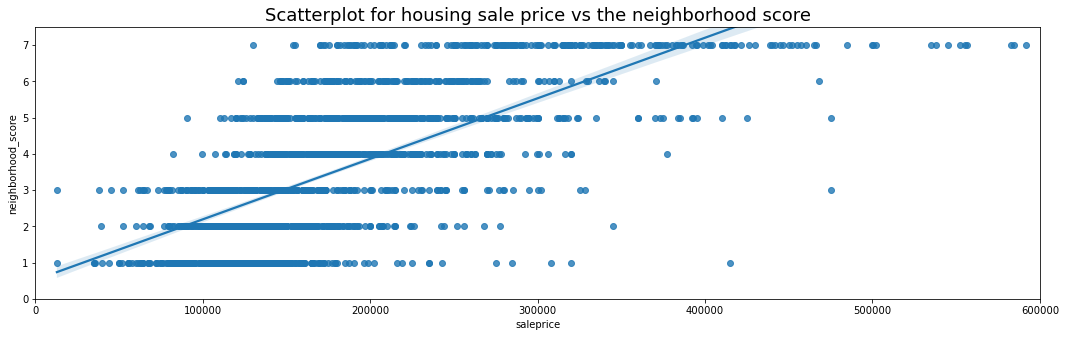

In [22]:
plt.figure(figsize=(18,5))
plt.title("Scatterplot for housing sale price vs the neighborhood score", fontsize=18)
plt.ylim(0, 7.5)
plt.xlim(0, 600000)
sns.regplot(x="saleprice", y="neighborhood_score", data=train);

The above scatterplot shows that the engineered neighborhood score feature as a linear relationship to the target variable (i.e. saleprices).

### Finally, we dummify the remaining categorical variables within the dataset, i.e. using one-hot code method. 

In [23]:
cols = ["central_air", "yr_sold"]

for i in cols:
    one_hot = pd.get_dummies(train[i], prefix=i, drop_first=True) 
    train = train.drop(i,axis = 1)
    train = train.join(one_hot)

In [24]:
### Move saleprice to final col
cols = train.columns.tolist()
cols = cols[0:18] + cols[19::] + cols[18:19] 
train = train[cols]

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2047
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lot_area               2048 non-null   int64  
 1   overall_qual           2048 non-null   int64  
 2   overall_cond           2048 non-null   int64  
 3   exter_qual             2048 non-null   int64  
 4   exter_cond             2048 non-null   int64  
 5   bsmt_qual              2048 non-null   int64  
 6   bsmt_cond              2048 non-null   int64  
 7   total_bsmt_sf          2048 non-null   float64
 8   heating_qc             2048 non-null   int64  
 9   gr_liv_area            2048 non-null   int64  
 10  kitchen_qual           2048 non-null   int64  
 11  fireplaces             2048 non-null   int64  
 12  fireplace_qu           2048 non-null   int64  
 13  garage_area            2048 non-null   float64
 14  garage_qual            2048 non-null   int64  
 15  gara

## Exploratory Data Analysis
---

### The distribution of housing sale price seems positively skewed. 

The mean housing sale price is $ 181437.11  (see red line below).


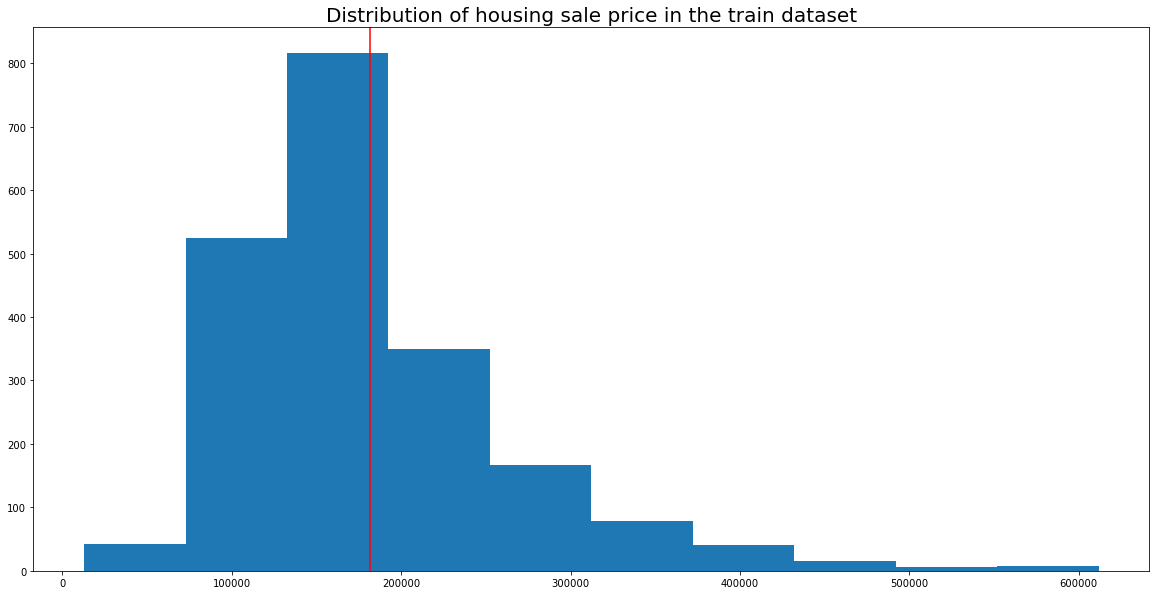

In [26]:
plt.figure(figsize=(20,10))
plt.title("Distribution of housing sale price in the train dataset", fontsize=20)
plt.hist(train["saleprice"])
plt.axvline(train["saleprice"].mean(), color="red")
print(f'The mean housing sale price is $',round(train["saleprice"].mean(),2),' (see red line below).')

C:\Users\PIZZAFEAST\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


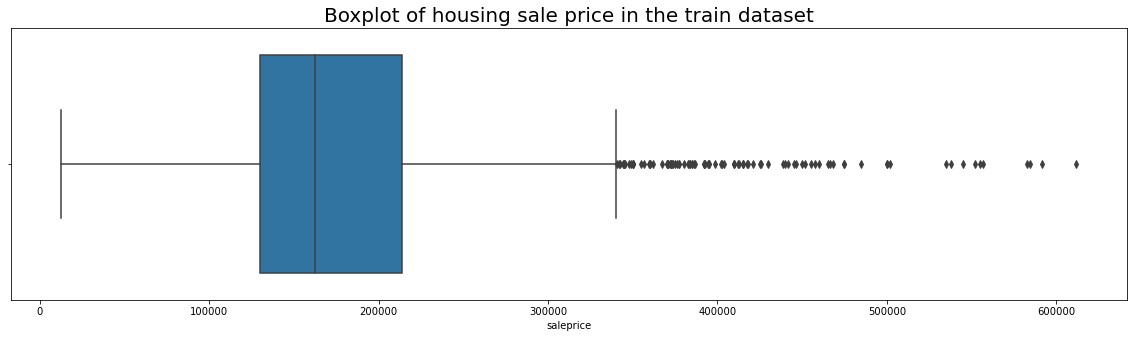

In [27]:
plt.figure(figsize=(20,5))
plt.title("Boxplot of housing sale price in the train dataset", fontsize=20)
sns.boxplot(train["saleprice"]);

There is a wide spread of housing prices with a significant number of outliers. 

The interquartile range is from \\$ 129725.00 to \$ 214000.00. 

### The variables most highly correlated with sale prices are:
- `overall_qual`
- `gr_liv_area`
- `exter_qual`
- `kitchen_qual`
- `neighborhood_score`


In [28]:
train.corr()["saleprice"].sort_values(ascending=False)[1:11]

overall_qual          0.803336
gr_liv_area           0.719598
exter_qual            0.714895
kitchen_qual          0.694159
neighborhood_score    0.688602
total_bsmt_sf         0.664912
garage_area           0.655215
bsmt_qual             0.613160
exter_qual*cond       0.597984
overall_qual*cond     0.566171
Name: saleprice, dtype: float64

### The summary statistics of the numerical, non-ordinal variables most correlated with sale prices are presented as follows:

In [29]:
train[["saleprice", "gr_liv_area", "total_bsmt_sf", "garage_area"]].describe().round(2).iloc[1::,:]

,saleprice,gr_liv_area,total_bsmt_sf,garage_area
mean,181437.11,1495.52,1052.79,472.63
std,79292.58,485.90,426.78,214.75
min,12789.00,334.00,0.00,0.00
25%,129725.00,1128.00,793.00,319.00
50%,162500.00,1443.00,994.00,480.00
75%,214000.00,1728.00,1316.25,576.00
max,611657.00,3820.00,3206.00,1356.00


A quick look at the numbers above tells us that sale prices share a positive relationship with the size of living area, basement area and garage area. However, the sale price is not exactly directly proportional to the size of these areas.

### For the strongest predictor, `overall_qual`, we take a further look at its distribution and boxplot below.

### Similar to the distribution of housing sale prices, the distribution of overall quality scores is also positively skewed but less so. This suggests there are other important variables to account for the variability in housing sale prices.

The mean overall quality is 6.11  out of 10 (see red line below).


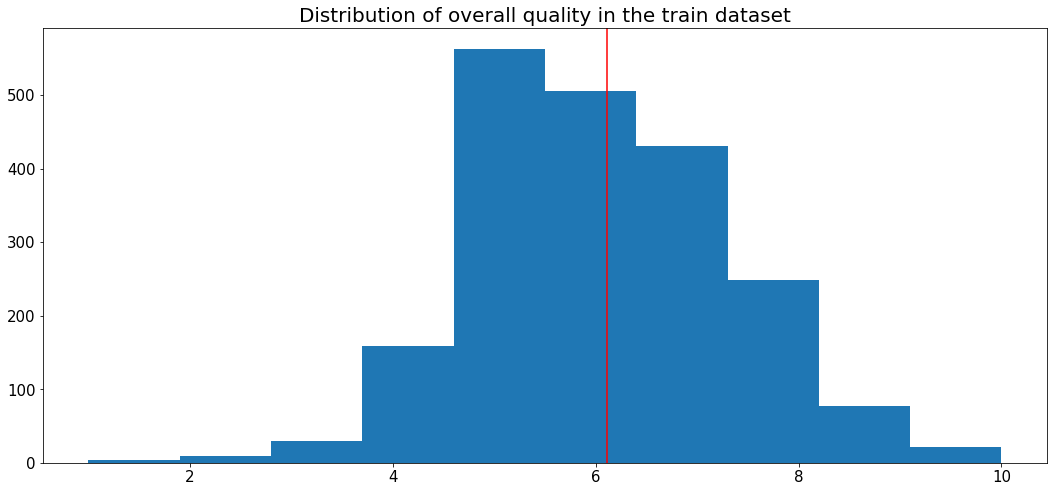

In [30]:
plt.figure(figsize=(18,8))
plt.title("Distribution of overall quality in the train dataset", fontsize=20)
plt.hist(train["overall_qual"])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(train["overall_qual"].mean(), color="red")
print(f'The mean overall quality is',round(train["overall_qual"].mean(),2),' out of 10 (see red line below).')

C:\Users\PIZZAFEAST\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


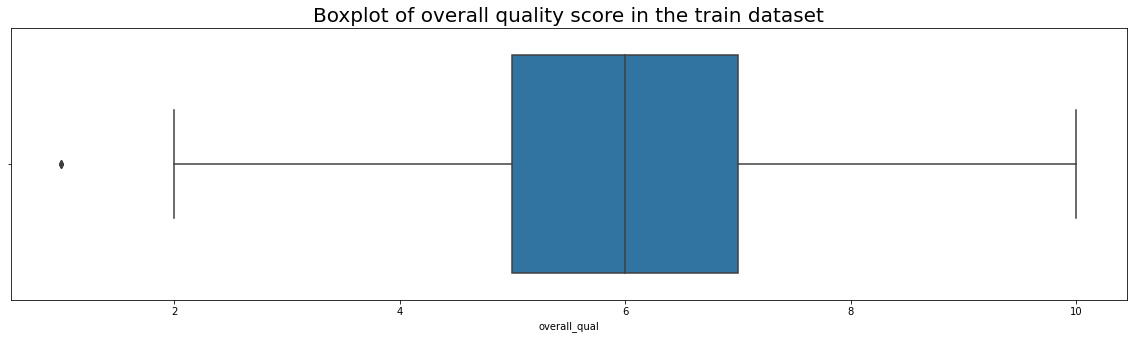

In [31]:
plt.figure(figsize=(20,5))
plt.title("Boxplot of overall quality score in the train dataset", fontsize=20)
sns.boxplot(train["overall_qual"]);

There is a wide range of overall quality scores observed across all housing units. Half of them score between 5 to 7 points (out of 10). 

### Now we plot a heatmap to look at the correlation matrix of the variables within the model.

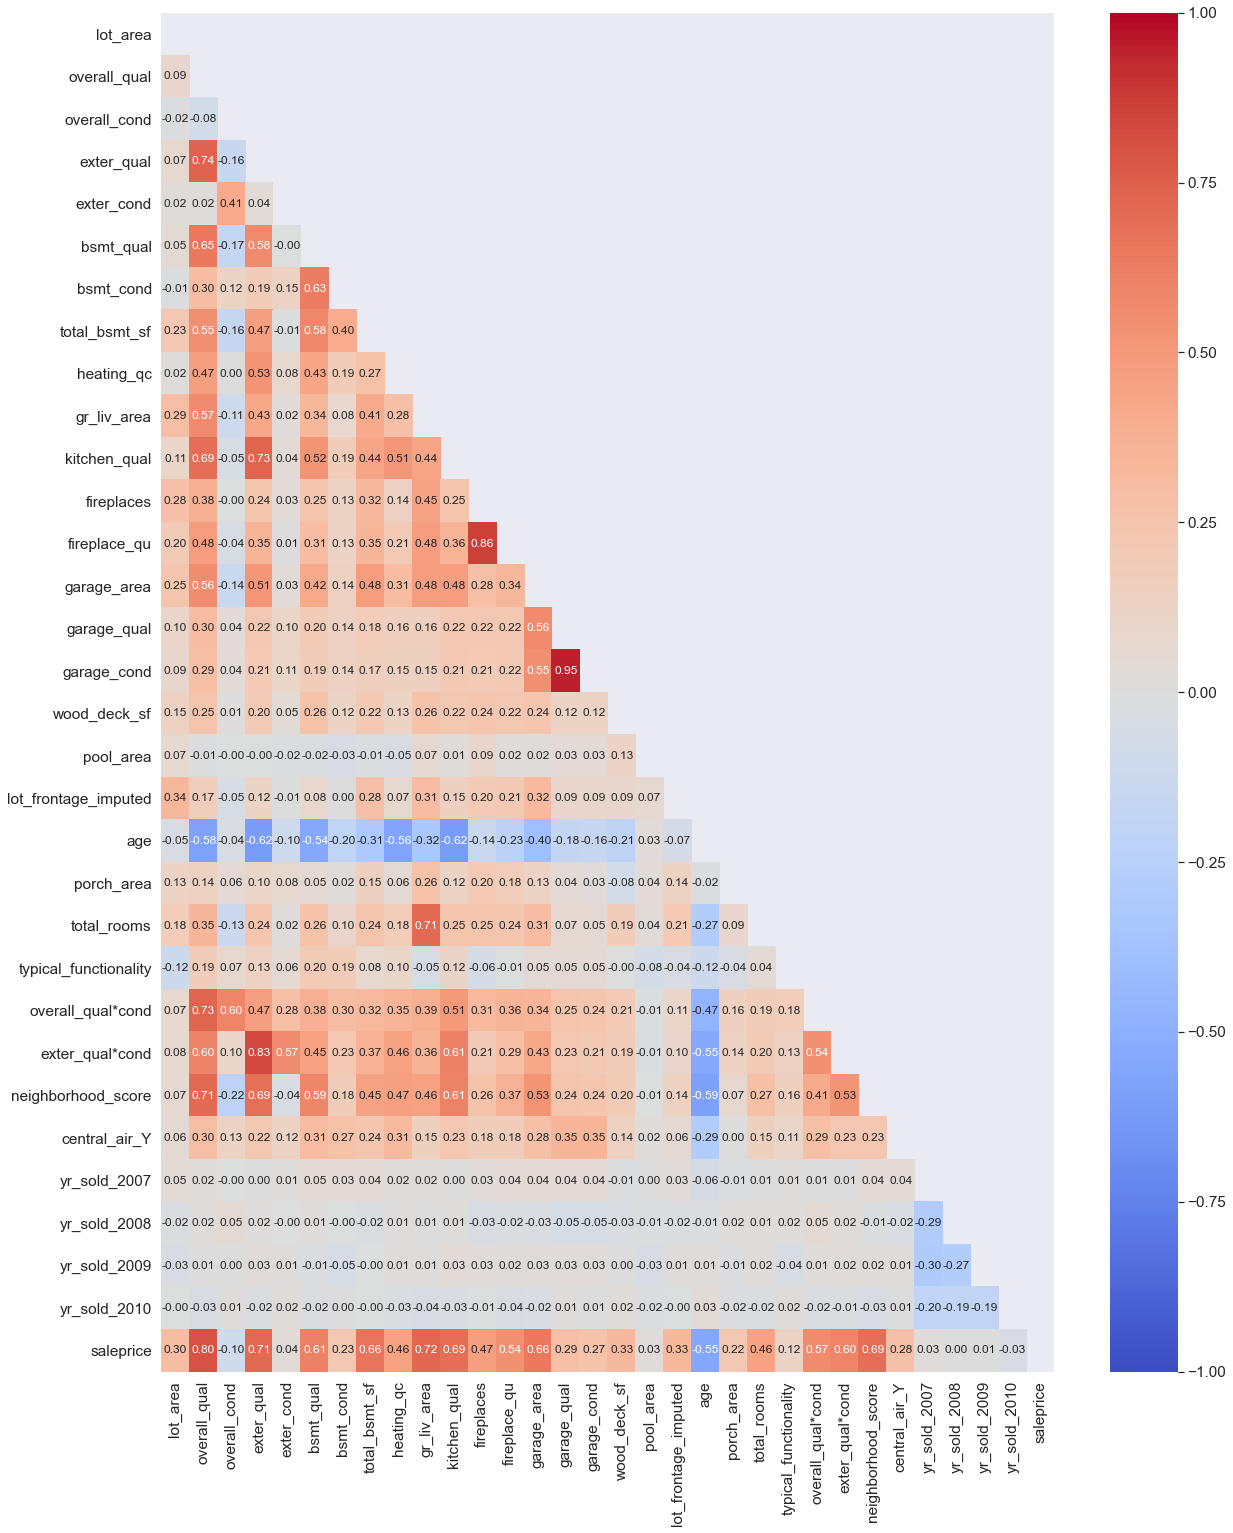

In [32]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(train.corr())

# Using the upper triangle matrix as mask 
plt.figure(figsize=(20,25))
sns.set(font_scale=1.4)
sns.heatmap(train.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

Focussing on the final row of the heatmap, ~1/3 of the chosen variables have moderately strong correlation with housing sale prices (r > 0.5), so it is likely that this set of variables will be able to help with the prediction of housing sale prices.

### We now focus on the dependent variables that are strongly correlated (r > 0.8) to avoid multicollinearity.

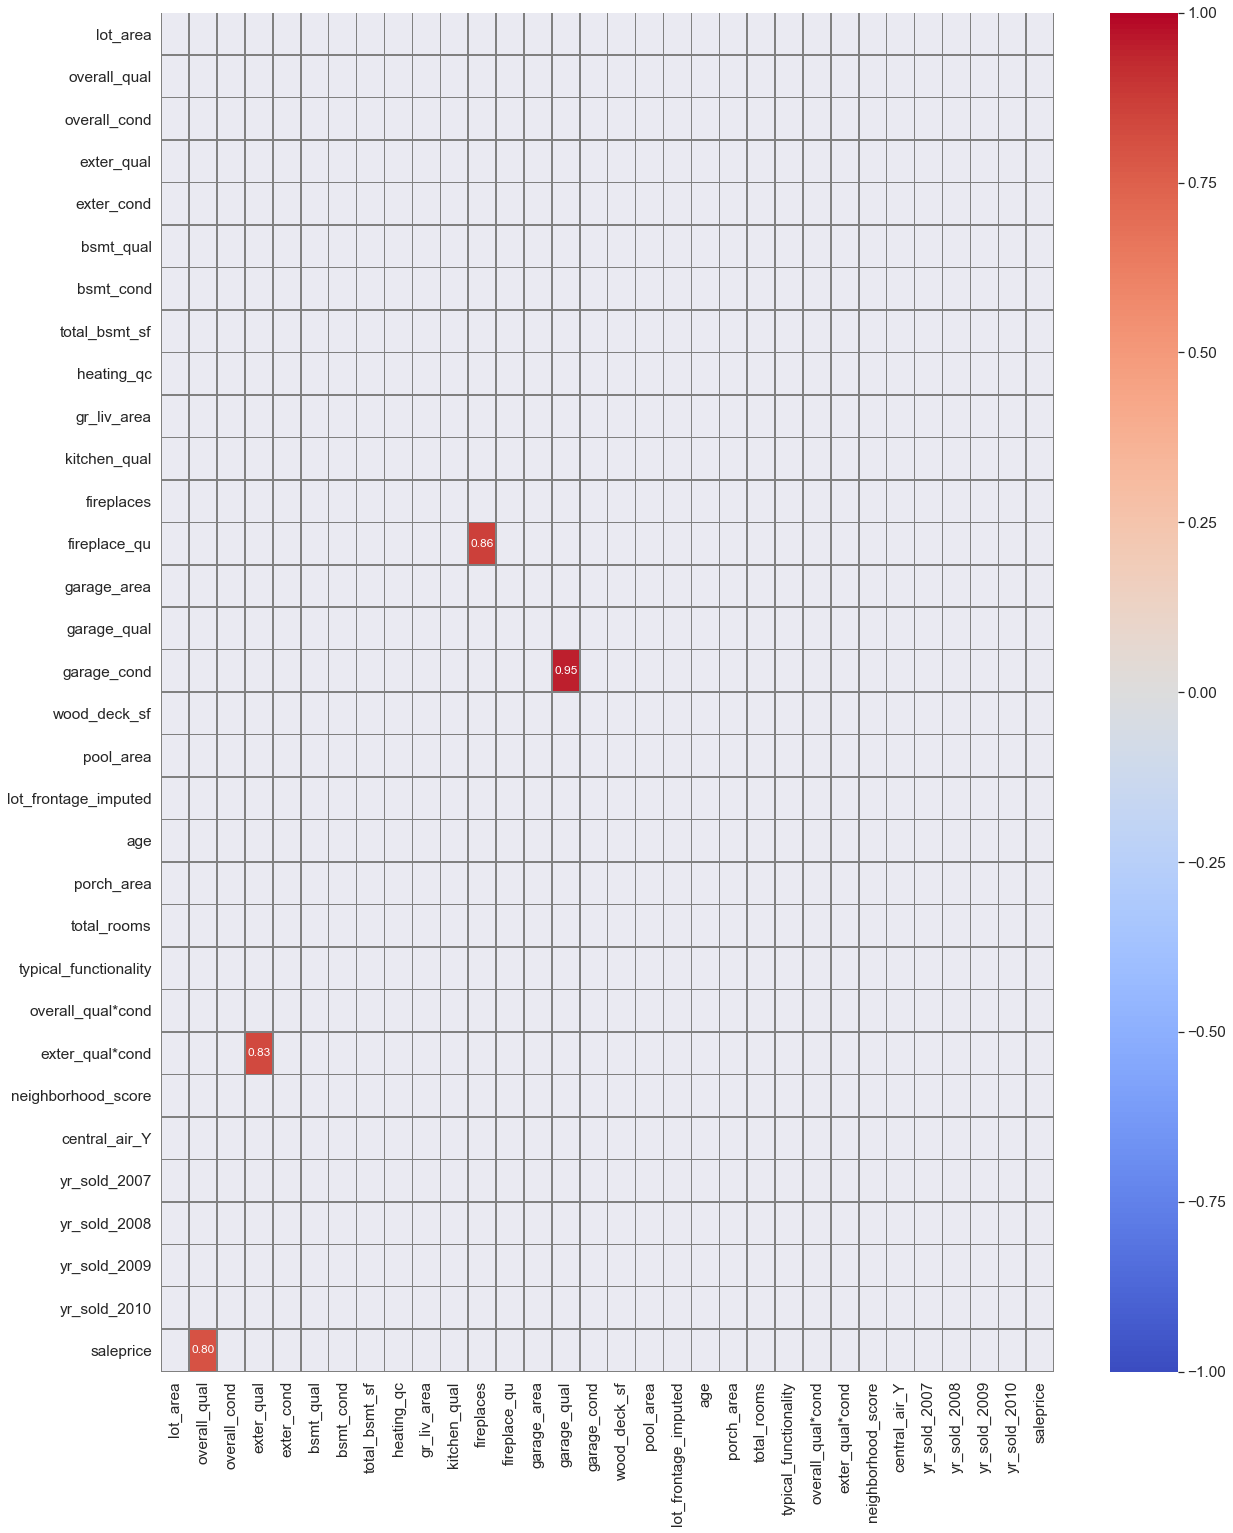

In [33]:
# Using the upper triangle matrix as mask 
plt.figure(figsize=(20,25))
sns.set(font_scale=1.4)
sns.heatmap(train.corr(), annot=True, mask= matrix | (np.abs(train.corr()) < 0.8), cmap="coolwarm", 
           fmt=".2f", linewidths=0.5, linecolor='grey', annot_kws={"size":12}, vmin=-1, vmax=1);

### Based on the heatmap above, we observe that `exter_qual*cond` `fireplaces` and `garage_cond` are highly related to `exter_qual`, `fireplace_qu` and `garage_qual` respectively. 

We drop `exter_qual*cond`, `fireplaces` and `garage_cond` from our train dataset as they are less correlated with the housing sale prices.

In [34]:
train.drop(["exter_qual*cond", "fireplaces", "garage_cond"], axis=1, inplace=True)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2047
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lot_area               2048 non-null   int64  
 1   overall_qual           2048 non-null   int64  
 2   overall_cond           2048 non-null   int64  
 3   exter_qual             2048 non-null   int64  
 4   exter_cond             2048 non-null   int64  
 5   bsmt_qual              2048 non-null   int64  
 6   bsmt_cond              2048 non-null   int64  
 7   total_bsmt_sf          2048 non-null   float64
 8   heating_qc             2048 non-null   int64  
 9   gr_liv_area            2048 non-null   int64  
 10  kitchen_qual           2048 non-null   int64  
 11  fireplace_qu           2048 non-null   int64  
 12  garage_area            2048 non-null   float64
 13  garage_qual            2048 non-null   int64  
 14  wood_deck_sf           2048 non-null   int64  
 15  pool

## Model Prep
---
### Create our features matrix (`X`) and target vector (`y`)

In [36]:
X = train.iloc[:,0:-1]
y = train["saleprice"]

### Train/test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

### Scaling 

In [38]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [39]:
print(f'X_train shape is: {X_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'X_test shape is: {X_test.shape}')
print(f'y_test shape is: {y_test.shape}')

X_train shape is: (1536, 28)
y_train shape is: (1536,)
X_test shape is: (512, 28)
y_test shape is: (512,)


### Instantiate the 3 models: OLS, Ridge, Lasso and fit the models to get preliminary R2 scores.

In [40]:
ols = LinearRegression()
ols.fit(X_train, y_train)
print("The ols R2 score for the train set is:", ols.score(X_train, y_train))
print("The ols R2 score for the test set is:", ols.score(X_test, y_test))
print("The difference between above scores is: ", round(ols.score(X_train, y_train) - ols.score(X_test, y_test), 5))

The ols R2 score for the train set is: 0.8697850894361996
The ols R2 score for the test set is: 0.8559667013821002
The difference between above scores is:  0.01382


In [41]:
ridge = RidgeCV(alphas=np.logspace(0, 5, 100), scoring='r2', cv=5)
ridge.fit(X_train, y_train)
print("The ridge R2 score for the train set is:", ridge.score(X_train, y_train))
print("The ridge R2 score for the test set is:", ridge.score(X_test, y_test))
print("The difference between above scores is: ", round(ridge.score(X_train, y_train) - ridge.score(X_test, y_test), 5))

The ridge R2 score for the train set is: 0.8692023944775626
The ridge R2 score for the test set is: 0.8533491619903459
The difference between above scores is:  0.01585


In [42]:
lasso = LassoCV(alphas=np.logspace(-3, 0, 100), cv=5)
lasso.fit(X_train, y_train)
print("The lasso R2 score for the train set is:", lasso.score(X_train, y_train))
print("The lasso R2 score for the test set is:", lasso.score(X_test, y_test))
print("The difference between above scores is: ", round(lasso.score(X_train, y_train) - lasso.score(X_test, y_test), 5))

The lasso R2 score for the train set is: 0.8697850517008336
The lasso R2 score for the test set is: 0.8559568451191233
The difference between above scores is:  0.01383


Typically, we choose the model that gives us the highest R2 scores for both train and test set as that would mean that the model is able to explain more variabilities observed in the depedent variable. At the same time, we also care about the difference between the R2 scores of the train and test data. A greater difference between both scores suggests that there may be a risk of overfitting to the train dataset and the model may not work as well on unseen data. 

### As the difference between the r2 scores of the train and test sets are not large across all three models, it is likely that any given model will generalise to new data. 

In [43]:
ols_scores = cross_val_score(ols, X_train, y_train, cv=5)
ols_scores.mean()

0.8584433631318849

In [44]:
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=5)
ridge_scores.mean()

0.8590951151372226

In [45]:
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=5)
lasso_scores.mean()

0.8584506945621694

### Based on the cross validation (cv) above, the ridge model looks the most promising as it has the highest mean cv r2 score. Therefore, we proceed with it for subsequent fitting with the entire train data.

### Scaling, Model Fitting and Evaluation


In [46]:
X_scaled = ss.fit_transform(X)

In [47]:
ridge.fit(X_scaled, y)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [48]:
ridge.score(X_scaled, y)

0.8610148239814746

### We plot a bar chart to look at the size of coefficients of the respective predictors in the model. 

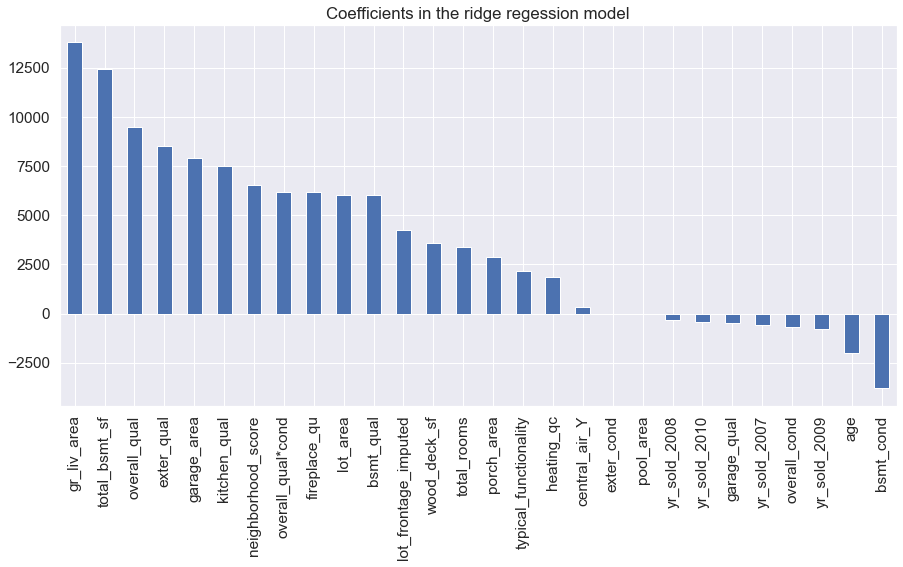

In [49]:
plt.title("Coefficients in the ridge regession model")
pd.Series(ridge.coef_, index=X.columns).sort_values(ascending=False).plot.bar(figsize=(15, 7));

Based on the above chart, we can infer the following:
- The size of ground living area, total basement area in square ft, garage area, lot area and etc. affects housing sale price significantly (the larger the areas, the higher the sale price).  


- The overall and external quality of the housing units are also key in influencing the housing sale prices (the higher the quality, the higher the sale price). If home sellers would like to increase the value of their houses at point of sale, they should take note to improve the overall, external and kitchen quality. 


- If a housing unit is based in a neighbourhood that is associated with more housing units having positive features (e.g. typical functionality, high overall and external quality and condition), the sale prices tend to be higher. This means that sellers putting up their homes in good neighborhood should not just price their houses for sale based on their unit-specific characteristics.  


- For dummy variables, we need to infer the coefficients relative to the dummy variable that was dropped. For example, for the dummy variable `central_air_Y`, which indicates 1 if the housing unit has central air conditioning, we interpret it's coefficient as the difference in housing sale price as compared to a housing unit without central air conditioning. In this case, houses with central air conditioning has a small premium over houses without given then small, positive coefficient value.

## Further model evaluation (against null or baseline)

In [50]:
pred = ridge.predict(X_scaled)
residuals = y - pred
mse = np.mean(residuals**2)
mse

873416729.8300011

In [51]:
y_bar = np.mean(y)
null_mse = np.mean((y - y_bar)**2)
null_mse

6284243793.838956

In [52]:
mse < null_mse

True

Mean squared error (MSE) is a useful scoring metric. The lower the score, the better the model performance. A model will get a lower score when the predictions generated are closer to the true values. As the MSE of the ridge model is lower than the MSE of the null/baseline model (involving the use of y_bar or mean y value as prediction values), our model is good for deployment and further testing. 

### The errors of the model seem normally distributed.

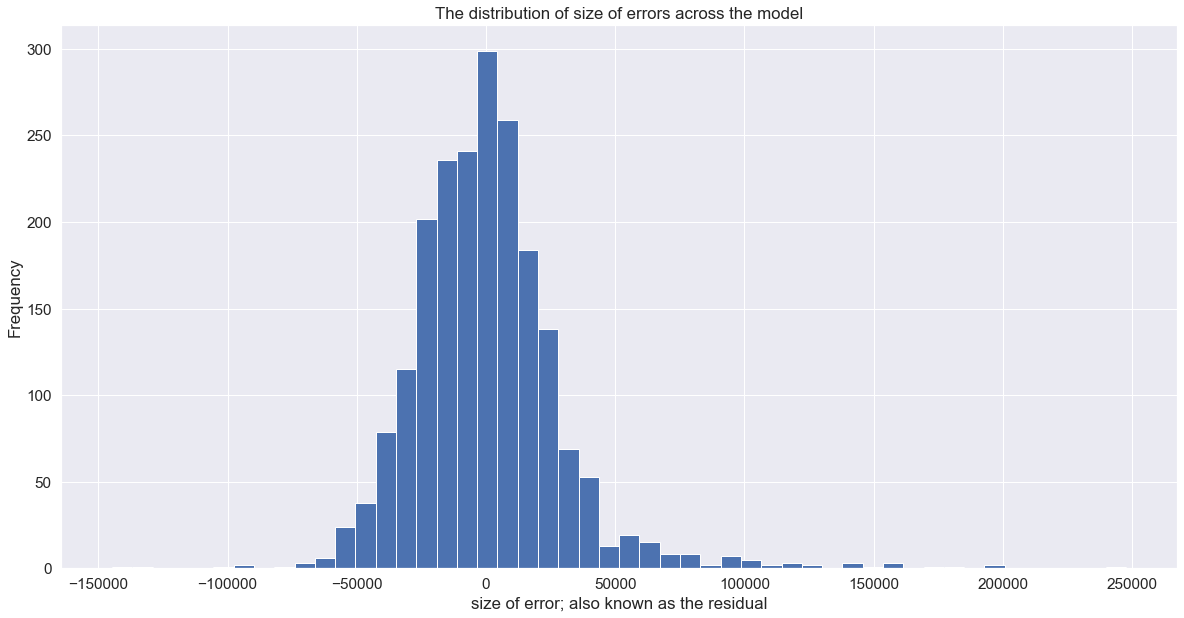

In [53]:
plt.figure(figsize=(20,10))
plt.title("The distribution of size of errors across the model")
plt.ylabel("Frequency")
plt.xlabel("size of error; also known as the residual")
plt.hist(residuals, bins=50);

### However, we might have issues with further model deployment as the variance for the errors is not equal across all predicted values, i.e. there is some heteroscedasticity implied by the plot below. 

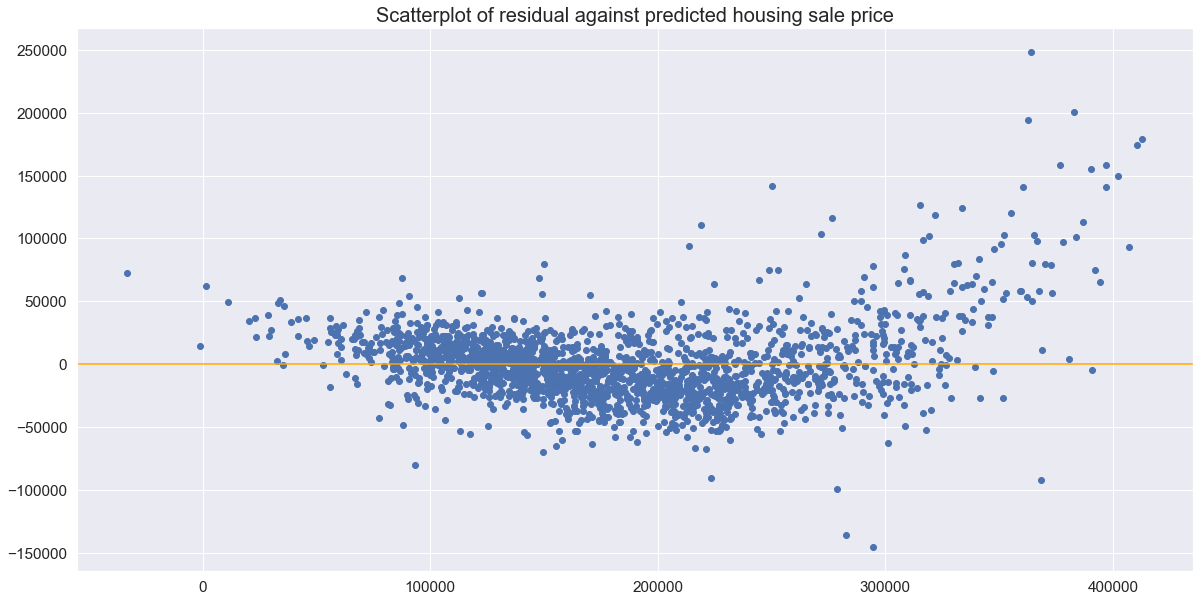

In [54]:
plt.figure(figsize=(20,10))
plt.title("Scatterplot of residual against predicted housing sale price", fontsize=20)
plt.scatter(pred, residuals)
plt.axhline(0, color="orange");

Regardless, we can proceed to clean the test data so that we can deploy the fitted model and test the prediction against the unseen data...

## Replicating the data cleaning steps for the test data

In [55]:
test = pd.read_csv("data/test.csv")
test.columns = test.columns.str.lower().str.replace(' ', '_')

FileNotFoundError: [Errno 2] No such file or directory: 'data/test.csv'

In [ ]:
test.drop(["id", "pid","ms_subclass", "ms_zoning", "street", "alley", "lot_shape", "utilities", "land_contour",
           "land_slope", "condition_1", "condition_2", "bldg_type", "house_style", "roof_style", "pool_qc",
           "roof_matl", "exterior_1st", "exterior_2nd", "mas_vnr_type", "mas_vnr_area", "foundation", "year_built",
           "bsmt_exposure", "bsmtfin_type_1", "bsmtfin_sf_1", "bsmtfin_type_2", "bsmtfin_sf_2", "bsmt_unf_sf",
           "heating", "electrical", "1st_flr_sf", "2nd_flr_sf", "low_qual_fin_sf", "totrms_abvgrd", 
           "garage_type", "garage_yr_blt", "garage_finish", "garage_cars", "paved_drive", "fence",  
            "misc_feature", "misc_val", "mo_sold", "sale_type"], 
           axis=1, inplace=True)

In [ ]:
test.groupby("lot_config")["lot_frontage"].mean()
test["lot_frontage_imputed"] = test["lot_frontage"]

lot_config = ["Corner", "CulDSac", "FR2", "FR3", "Inside"]
for i in lot_config:
    test.loc[(test["lot_frontage"].isna()) & (test["lot_config"]==i), "lot_frontage_imputed"] \
    = test.groupby("lot_config")["lot_frontage"].mean()[i]

test.drop(["lot_frontage", "lot_config"], inplace=True, axis=1)

In [ ]:
missing_var = ["fireplace_qu", "bsmt_qual", "bsmt_full_bath", "bsmt_half_bath", "garage_area",
              "garage_qual", "total_bsmt_sf", "garage_cond", "bsmt_cond", "exter_cond", "pool_area"]

for i in missing_var:
    if test[i].dtype == "O":
        test[i].fillna("NA", inplace=True)
    else:
        test[i].fillna(0, inplace=True)

In [ ]:
test["age"] = test["yr_sold"] - test["year_remod/add"]
test["porch_area"] = test["open_porch_sf"] + test["enclosed_porch"] + test["3ssn_porch"] + test["screen_porch"]
test["total_rooms"] = test["full_bath"] + test["half_bath"] +test["bedroom_abvgr"] + test["kitchen_abvgr"] + test["bsmt_full_bath"] + test["bsmt_half_bath"]

test.drop(["year_remod/add", "open_porch_sf", "enclosed_porch", "3ssn_porch", "screen_porch",
            "full_bath", "half_bath", "bedroom_abvgr", "kitchen_abvgr", "bsmt_full_bath", "bsmt_half_bath"], 
           axis=1, inplace=True)

In [ ]:
ordinal_var = ["bsmt_qual", "heating_qc", "kitchen_qual", "fireplace_qu", "garage_qual", "exter_qual",
              "exter_cond", "bsmt_cond", "garage_cond"]

for i in ordinal_var:
    test[i].replace({"Ex": 5, "Gd":4, "TA": 3, "Fa": 2, "Po":1, "NA": 0}, inplace=True)

In [ ]:
test["typical_functionality"] = 0
test.loc[(test["functional"] == "Typ"), "typical_functionality"] = 1
test.drop("functional", axis=1, inplace=True)

test["overall_qual*cond"] = test["overall_qual"] * test["overall_cond"]
test["exter_qual*cond"] = test["exter_qual"] * test["exter_cond"]

neighborhd = test.groupby("neighborhood", as_index=False)[["typical_functionality", "overall_qual*cond", "exter_qual*cond"]].mean()
neighborhd["tf_rank"] = neighborhd["typical_functionality"].rank()
neighborhd["overall_rank"] = neighborhd["overall_qual*cond"].rank()
neighborhd["exter_rank"] = neighborhd["exter_qual*cond"].rank()
neighborhd["composite_rank_score"] = neighborhd["tf_rank"] + neighborhd["overall_rank"] + neighborhd["exter_rank"]
neighborhd["rank_order"] = neighborhd["composite_rank_score"].rank()

neighborhd["neighborhood_score"] = 0
neighborhd.loc[(neighborhd["rank_order"] <= 4), "neighborhood_score"] = 1
neighborhd.loc[(neighborhd["rank_order"] <= 8) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 2
neighborhd.loc[(neighborhd["rank_order"] <= 12) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 3
neighborhd.loc[(neighborhd["rank_order"] <= 16) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 4
neighborhd.loc[(neighborhd["rank_order"] <= 20) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 5
neighborhd.loc[(neighborhd["rank_order"] <= 24) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 6
neighborhd.loc[(neighborhd["rank_order"] <= 28) & (neighborhd["neighborhood_score"]==0), "neighborhood_score"] = 7

test = test.merge(neighborhd[["neighborhood", "neighborhood_score"]], how="inner", on="neighborhood")
test.drop("neighborhood", axis=1, inplace=True)

In [ ]:
cols = ["central_air", "yr_sold"]

for i in cols:
    one_hot = pd.get_dummies(test[i], prefix=i, drop_first=True) 
    test = test.drop(i,axis = 1)
    test = test.join(one_hot)

In [ ]:
test.drop(["exter_qual*cond", "fireplaces", "garage_cond"], axis=1, inplace=True)

## Predicting the housing sale prices for the test data

In [ ]:
test_scaled = ss.transform(test)

In [ ]:
df = pd.DataFrame({'saleprice':ridge.predict(test_scaled)})
df

In [ ]:
kaggle_id = pd.read_csv("data/test.csv")
kaggle_id = kaggle_id.iloc[:,0:1]
kaggle_id

In [ ]:
kaggle_sub = pd.concat([kaggle_id, df.reset_index(drop=True)], axis=1)

In [ ]:
kaggle_sub.to_csv("kaggle_submission_dsi23_lee_shi_min.csv", index=False)

## Conclusion
---

**Key Findings:**

After submitting the predicted housing sale prices to kaggle, we obtained a **very high RMSE score of more than 100,000**. This suggests that our model is **not** generalizable to unseen data. As the RMSE is much higher than \$10,000 (i.e. the estimated cost of imperfect information in the housing market - see background), it is **unlikely that home sellers will benefit from the use of this sale price prediction model**. 

Nevertheless, we learn from this modelling exercise that the quality of the housing aspects are much more important than its corresponding condition. Home sellers hoping to raise the value of their future housing sales should look into improving the overall, external quality of their homes. 

This failure of this data science project could be due to the highly restrictive feature selection process from the outset. As there is a large spread and types of housing units included in the training and test datasets, inclusion of more features ( > 30) will be required to train the model and account for more variations in sale prices of the unseen data. 

**Recommendation:**

We recommend for a ***new*** model to be developed to improve housing sale price prediction with at least 30 housing features incorporated as the existing model is too weak in terms of sale price prediction to be useful for our stakeholders. Perhaps, a better way to approach feature selection in this context is to include all variables from the outset and apply lasso regression to regularize the model. 

**Future Scope:**

Beyond building a more complex model for housing sale price predictions, data scientist can also replicate the modelling process using housing sales dataset from other regions in the US (outside of Ames, Iowa) in future so that the model can be extended to predict housing prices in other geographical areas. 